# Investigating the Traveling Salesman Problem with metaheuristics

* Andris Jansons
* Daniel Jones
* Joshua Sonde


[https://github.coventry.ac.uk/380CT-2021/Group-07](https://github.coventry.ac.uk/380CT-2021/Group-07)

_Note: Some LaTeX doesn't render correctly in GitHub, so it is advised to open this notebook in JupyterLab._

Start by importing the relevant libraries

In [1]:
from random import random, choice, choices, randint, shuffle, sample, uniform # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from itertools import chain # concatenate range()'s'
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
from typing import Tuple # additional type hint support
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
import numpy as np
sns.set_style("white")

# 1) Notation and definitions

Let $G$ be a [complete]( "graph is undirected, has no self-loops, and each node is connected to all the other vertices")  [weighted]( "the edges have a weight (a positive integer)") graph with $n$ vertices.

**Optimisation TSP**:
> Given $G$, find a cycle of minimal total cost.

This problem is **NP-Hard** because its decision version is **NP-complete** (Garey and Johnson, 1979, p. 211).

* **Greedy and meta-heuristics**:
    Average _time_ and _"quality"_ as $n$ increases.

Instances will be generated randomly as shown in the next subsection.

# 2) Testing methodology

## 2.1) Comparing greedy and meta-heuristics
Tests on average _time_ and _"quality"_ as number of cities ($n$) increases.

Metaheuristic algorithms will be compared against the greedy nearest neighbour algorithm and the relative time change and weight change ("quality") will be collected. The test will be performed for 4 types of graphs that will be generated randomly as shown in the next subsection. The test will start with 2 cities in the graph and increase the number of cities by 3 until 100. For each number of cities in the graph, the test will be repeated 5 times.

These comparison results can then be graphed showing how the performance and quality differs between them.

The graphs will use a percent scale, where positive 100% indicate that the metaheuristic algorithm performs 2 times better and negative -100% indicate that it performs 2 times worse.

Below is the code for comparing the algorithms and graphing the results.

In [2]:
def compare_algorithms(graph_type, algorithm, baseline_algorithm=lambda G: greedy_nearest_neighbour(G), \
                       n_range=range(2, 100, 3), repetitions=5):
    """
    Evaluate an algorithm against another algorithm.
    Comparison happens for a graph of graph_type with vertices in n_range.
    Each test is repeated repetitions times.
    """
    results = pd.DataFrame(columns=['n', 'time', 'quality'])

    i = 0
    for n in n_range:
        print(n, end='')
        for repetition in range(repetitions):
            print('.', end='')
            G = Graph(n, graph_type)

            # Solve with Baseline algorithm
            baseline_start_time = perf_counter()
            baseline_path, baseline_weight = baseline_algorithm(G)
            baseline_end_time = perf_counter()

            # Solve with the specific algorithm
            start_time = perf_counter()
            path, weight = algorithm(G)
            end_time = perf_counter()

            # Compare time as a percentage difference
            # A negative 100% indicates algorithm taking twice as much time as the baseline algorithm
            baseline_time = baseline_end_time - baseline_start_time
            time = end_time - start_time
            time_difference = (time - baseline_time) / baseline_time * 100 * -1
            # Compare quality as a percentage difference
            # A positive 100% indicate that tne algorithm can produce a result with
            # 2 times less weight than the baseline algorithm can produce for the same graph
            quality_difference = (weight - baseline_weight) / baseline_weight * 100 * -1
            
            # Collect data
            results.loc[i] = [n, time_difference, quality_difference]
            i += 1
    
    return results

def graph_results(results):
    """Display results from compare_algorithms function on graphs"""
    fig, (time, quality) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    
    sns.scatterplot(data=results, x='n', y='time', alpha=0.3, ax=time, color='#777')
    sns.lineplot(data=results, x='n', y='time', ci='sd', ax=time, color='red')
    time.set_title('Relative time change over number of cities');
    time.set_xlabel('Number of cities (count)')
    time.set_ylabel('Relative time change (%)')

    sns.scatterplot(data=results, x='n', y='quality', alpha=0.3, ax=quality, color='#777')
    sns.lineplot(data=results, x='n', y='quality', ci='sd', ax=quality, color='green')
    quality.set_title('Relative weight change over number of cities');
    quality.set_xlabel('Number of cities (count)')
    quality.set_ylabel('Relative weight change (%)')

## 2.2) Random instances sampling strategy

Four types of TSP instances will be generated by creating an **adjacency matrices** $M$ as follows:
1. **Asymmetric**: The edge weights are independent and uniformly random in an interval $[1,\text{MAX_WEIGHT}]$, i.e the graph is assumed to be directed.
2. **Symmetric**: Like the asymmetric case but the graph is undirected, and the matrix is therefore symmetric: $M_{ij}=M_{ji}$.
3. **Euclidean**: Generate points using $(x,y)$ coordinates, then generate the adjacency matrix by calculating all the required distances. Recall that the distance between two points $(x_1,y_1)$ and $(x_2,y_2)$ is $\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$. The points are generated in the rectangle defined by the points $(0,0)$ and $(\text{MAX_Y},\text{MAX_Y})$.
4. **Graphs with obvious shortest cycle**: A graph where all the distances are 2 except for the edges on a predefined cycle, where the distance is 1. Such a graph would be useful for testing/debugging the "nearest neighbour greedy" search.

### 2.2.1) Implementation of the instances generation

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

For simplicity, we will consider $0$ to be the start and end point of cycles.

In [3]:
class Graph:
    ''' Random graphs '''
    def __init__(self, n=0, type='asymmetric', MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if   type=='symmetric': self.__random_symmetric_graph(n,MAX_WEIGHT)
        elif type=='Euclidean': self.__random_euclidean_graph(n,MAX_X,MAX_Y)
        elif type=='easy':      self.__random_cycle_graph(n)
        else:                   self.__random_asymmetric_graph(n,MAX_WEIGHT) # assume 'asymmetric' otherwise
            
    def __getitem__(self, i):
        ''' Allow indexing to get the weights '''
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self,n, MAX_WEIGHT):
        ''' Asymmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(n):
                if i==j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1,MAX_WEIGHT)

    def __random_symmetric_graph(self,n,MAX_WEIGHT):
        ''' Symmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(i+1,n):
                w = randint(1,MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        ''' Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) '''
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1,n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a,b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self,n,MAX_X,MAX_Y):
        ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points)<n: # We may get duplicate (x,y) so we try until we get enough points
            x,y = randint(0,MAX_X), randint(0,MAX_Y)
            points.add((x,y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1,n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points=points

In [4]:
def cost(G, cycle):
    """ Calculate the cost of the given cycle [0,...,0] in G """
    return sum(G[a][b] for a, b in zip(cycle, cycle[1:]))

### 2.2.2) Utility functions on the Graph

- **show(Graph)**: Displays the adjacency matrix of the graph.
- **draw(Graph, path?, weight_tags?)**: Draws the graph. If a path is specified, only draws the edges in the path. If weight_tags is set to True, displays the weights on the edges.

In [5]:
def show(G):
    ''' Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    '''
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type=='Euclidean': print("Points:",G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)
    
def nx_graph(G, path=None):
    ''' Convert G into NetworkX format '''
    nxG = nx.Graph() if G.type!='asymmetric' else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    if path is None:
        # If no specific path is given - Add all edges
        for a in G.vertices:
            for b in G.vertices:
                if a==b: continue # no self-loops
                nxG.add_edge(a, b, weight=G[a][b])
    else:
        # If path is given - Add only edges specified in path
        for i in range(len(path) - 1):
            a = path[i]
            b = path[i + 1]
            nxG.add_edge(a, b, weight=G[a][b])
    if G.type=='Euclidean': # add (x,y) coordinates if available
        pos=dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, 'coord')
    return nxG

def draw(G, path=None, weight_tags=False):
    ''' Draw the graph G using NetworkX '''
    nxG = nx_graph(G, path)
    weights_dictionary = nx.get_edge_attributes(nxG,'weight')
    edges,weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type!='Euclidean' else nx.get_node_attributes(nxG,'coord')
    nx.draw(nxG, pos, \
            with_labels=True, node_color='red', font_color='white', font_weight='bold', font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3,rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    if weight_tags:
        nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary)

## 3) Nearest Neigbour Greedy method

#### Idea

Start at city 0, move to the nearest city, then from there to the next nearest city, and so on, until all cities are visited. Finally, return back to the start city.

#### Pseudocode

1. $city \gets 0$
2. $visited\gets []$
3. **while** not all cities are visited **do**
4. $\quad$ $nearest\_city \gets \text{nearest city to $city$ that has not been visited yet}$
5. $\quad$ Append $city$ to $visited$ $\qquad\qquad\text{(i.e. mark $city$ as visited)}$
5. $\quad$ $city\gets nearest\_city$
6. **end while**
8. **return** $visited$

#### Running time analysis

The while-loop costs $O(n)$, and searching for the nearest city on line 4 costs $O(n)$ also, while the rest can be assumed to cost $O(1)$.
So the total cost of this greedy approach is therefore $O(n)\times O(n) = O(n^2)$.

#### Implementation

In [6]:
def greedy_nearest_neighbour(G):
    ''' Returns best found cycle and its cost '''
    unvisited = G.vertices.copy()
    visited = [] # solution to be built
    city = 0 # Start city
    while len(unvisited)>0:
        # Find nearest neighbour
        nearest_city = None
        shortest_distance = oo
        for neighbour in unvisited:
            if G[city][neighbour] < shortest_distance:
                shortest_distance = G[city][neighbour]
                nearest_city = neighbour
        # Update 'cycle' and 'cities' and G then 'city'
        visited.append(city)
        unvisited.remove(city)
        city = nearest_city
    # Add starting city to visited
    visited.append(visited[0])
    return visited, cost(G, visited)

# 4) Metaheuristics

## 4.1) Ant Colony Optimisation

### 4.1.1) Idea
Ant Colony Optimisation algorithm is a biologically-inspired metaheuristic which searches solution space by emulating the way ant colonies search for food (Dorigo, Maniezzo, Colorni, 1996).

Ants are able to locate food and without any direct form of communication with the colony they can coordinate retrieving it. The communication between ants happens through the use of pheromone. Once food is found ants leave the pheromone on their path. As more pheromone builds up, more ants will follow the discovered path to the food.

The algorithm can be implemented in roughly the following steps (Le, Peechatt, 2019):
1. Put ants on random cities.
1. For each ant, send the ant to all the other cities where they visit each city only once. The selection for which city to visit is initially random. After the first run, the next city selection becomes gradually more influenced by the amount of pheromone on a possible trail.
1. Once all ants have completed a tour of all cities, deposit pheromone on all paths. The amount of pheromone deposited by each ant is proportional to the length of the path traveled by the given ant.
1. Repeat the previous steps for multiple generations of ants.

<a id='city-selection'></a>
#### 4.1.1.1) City selection
Ants select the next city to visit by making a random choice which is influenced by a probability. At each city, a probability distribution for next city selection from a list of possibilities is generated according to the following:

$\Large p_{ij} = \frac{(\tau_{ij}^{\alpha}) (\eta_{ij}^{\beta})}{\sum_{h \in E} (\tau_{ih}^{\alpha}) (\eta_{ih}^{\beta})}$

Where:
- **$i$** is the current city
- **$j$** is an unvisited city
- **$\tau_{ij}$** is the amount of pheromone on the trail between city $i$ and city $j$
- **$\eta_{ij}$** is the desirability of city $i$ relative to city $j$ (formulated as the inverse of the distance between $i$ and $j$)
- **$\alpha$** is the weighting factor for the pheromone
- **$\beta$** is the weighting factor for the desirability
- **$h$** is a city from the list of available (unvisited) cities
- **$E$** is a list of available (unvisited) cities

<a id='pheromone-update'></a>
#### 4.1.1.2) Pheromone update
When all ants in a generation have completed their trips, the global pheromone trail is updated by each of them. The pheromone update from city $i$ to city $j$ is calculated with the following formula:

$\Large \tau_{ij} \gets \rho \tau_{ij} + \sum_{k}^{m} \Delta\tau_{ij}^{k}$

Where:
- **$i$** is the current city
- **$j$** is an unvisited city
- **$\tau_{ij}$** is the amount of pheromone on the trail between city $i$ and city $j$
- **$\rho$** pheromone residual coefficient (0-1), how fast the pheromone evaporates
- **$m$** is the number of ants
- **$\Delta\tau_{ij}^{k}$** is the amount of pheromone deposited by $k$th ant between city $i$ and city $j$

The pheromone deposited by $k$th ant between city $i$ and city $j$ is calculated by:

$\Large \Delta\tau_{ij}^{k} = \normalsize \begin{cases} Q/L_{k} \hspace{7mm} \text{if ant $k$ uses edge $ij$ in its tour} \\ 0 \hspace{15mm} \text{otherwise} \end{cases}$

Where:
- **$L_{k}$** is the cost of $k$th ant's path
- **$Q$** is the pheromone intensity

### 4.1.2) Pseudocode

1. $n \gets \text{number of cities in graph}$
1. $generations \gets 10$
1. $ant\_count \gets 20$
1. $pheromones \gets \text{$n \times n$ matrix with initial values as $\frac{1}{n^2}$}$
1. $best\_path \gets []$
1. **for** $i \gets 1, ..., generations$ **do**
1. $\quad$ $ants \gets []$ 
1. $\quad$ **for** $j \gets 1, ..., ant\_count$ **do**
1. $\quad\quad$ $ant \gets$ create new Ant
1. $\quad\quad$ $path \gets []$
1. $\quad\quad$ **while** not all cities in $path$ **do**
1. $\quad\quad\quad$ $city \gets$ Choose the next unvisited city for $ant$ to visit according to [City selection](#city-selection) (see section 4.1.1.1)
1. $\quad\quad\quad$ Append $city$ to $path$
1. $\quad\quad$ **end while**
1. $\quad\quad$ **if** cost of $path$ $<$ cost of $best\_path$ **then**
1. $\quad\quad\quad$ $best\_path \gets path$
1. $\quad\quad$ **end if**
1. $\quad\quad$ Append $ant$ to $ants$
1. $\quad$ **end for**
1. $\quad$ Update $pheromones$ according to [Pheromone update](#pheromone-update) (see section 4.1.1.2)
1. **end for**
1. **return** $best\_path$

### 4.1.3) Big O analysis

Time Complexity: $O(n^{2} \times m \times g)$ = $O(n^2)$

Where:
- **$n$** is the number of cities in the graph
- **$m$** is the ant count per generation
- **$g$** is the generation count

Assuming that the ant count $m$ and generation count $g$ doesn't change depending on the number of cities $n$ in the graph, we can assume that they will always run in constant time $O(1)$, which means that the Ant Colony Optimisation algorithm on the Travelling Salesman Problem runs in polynomial time and its time complexity is $O(n^2)$

### 4.1.4) Implementation

In [7]:
class AntColonyOptimisation:
    def __init__(self, ant_count=20, generations=10, alpha=1.0, beta=10.0, \
                 residual_coefficient=0.5, pheromone_intensity=10.0, verbose=False):
        self.ant_count = ant_count  # Ants per generation
        self.generations = generations  # Total ant generations
        self.alpha = alpha  # Relative importance of pheromone
        self.beta = beta  # Relative importance of desirability
        self.residual_coefficient = residual_coefficient  # Pheromone residual coefficient
        self.pheromone_intensity = pheromone_intensity  # Pheromone intensity
        self.verbose = verbose  # Whether should print intermediate decisions
    
    def solve(self, graph):
        best_cost = float('inf')
        best_solution = []
        
        # Pheromones is a N by N matrix with each initial pheromone set as 1 / (N**2),
        # where N is the number of cities in the graph
        pheromones = [[1 / (graph.n ** 2) for j in range(graph.n)] for i in range(graph.n)]
        
        for generation in range(self.generations):
            ants = [Ant(self, graph, pheromones) for i in range(self.ant_count)]
            for ant in ants:
                curr_costs = []
                for i in range(graph.n - 1):
                    # Move the ant between all cities
                    ant.select_next_city()
                # Finish the trip by moving the ant back to the starting city 
                ant.move_to_start_city()
                # Update costs
                curr_costs.append(ant.total_cost)
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = ant.path.copy()
                # Update ant pheromone delta
                ant.update_pheromone_delta()
            # Update pheromones to influence next generations path
            self.update_pheromones(pheromones, ants)
            # Debugging
            if self.verbose:
                print('Generation #{} best cost: {}, avg cost: {}, path: {}'.format(
                    generation + 1, best_cost, np.mean(curr_costs), best_solution))
        return best_solution, best_cost
            
    
    def update_pheromones(self, pheromones, ants):
        for i, row in enumerate(pheromones):
            for j, col in enumerate(row):
                pheromones[i][j] *= self.residual_coefficient
                for ant in ants:
                    pheromones[i][j] += ant.pheromone_delta[i][j]

                    
class Ant:
    def __init__(self, ant_colony, graph, pheromones):
        self.ant_colony = ant_colony
        self.graph = graph
        self.pheromones = pheromones
        self.total_cost = 0.0
        self.path = []  # List of the path taken by the ant
        self.pheromone_delta = []  # The local increase of pheromone
        # Cities which are available for next selection
        self.allowed_cities = graph.vertices.copy()
        # Create an N by N matrix with the desirability of each city
        # formulated as the inverse of the distance between cities
        self.desirability = [[0 if i == j else (1 / graph[i][j]) for j in graph.vertices] for i in graph.vertices]

        self.start = randint(0, graph.n - 1)  # Start from any node
        self._move_to_city(self.start)

    def select_next_city(self):
        """
        Select the next city influenced by the pheromone and its desirability
        and move the ant to that city
        """
        # Calculate probability denominator as sum of probability to all unvisited cities
        denominator = 0
        for i in self.allowed_cities:
            denominator += self._get_pheromone(i)  * self._get_desirability(i)

        # Probability for moving to a city in the next step
        probabilities = [0 for i in self.graph.vertices]
        for i in self.graph.vertices:
            if denominator == 0 or i not in self.allowed_cities:
                continue
            probabilities[i] = self._get_pheromone(i)  * self._get_desirability(i) / denominator

        # Select next city randomly based on the probabilities
        # Visited cities have a probability of 0, so they won't be chosen
        next_city = np.random.choice(self.graph.vertices, p=probabilities)

        self.total_cost += self.get_distance(next_city)
        self._move_to_city(next_city)

    def update_pheromone_delta(self):
        """Place pheromone on the path proportional to the total cost of the path"""
        self.pheromone_delta = [[0 for j in self.graph.vertices] for i in self.graph.vertices]
        for _ in range(1, len(self.path)):
            i = self.path[_ - 1]
            j = self.path[_]
            self.pheromone_delta[i][j] = self.ant_colony.pheromone_intensity / self.total_cost

    def get_distance(self, city):
        """Get the distance of moving to the next city"""
        return self.graph[self.current][city]
    
    def move_to_start_city(self):
        """Finish the ant's trip by moving back to the starting city"""
        self.total_cost += self.get_distance(self.start)
        self.path.append(self.start)
            
    def _get_pheromone(self, city):
        """Get the pheromone to the city from the current location with the relative imporance"""
        return self.pheromones[self.current][city] ** self.ant_colony.alpha

    def _get_desirability(self, city):
        """Get the desirability to the city from the current location with the relative importance"""
        return self.desirability[self.current][city] ** self.ant_colony.beta

    def _move_to_city(self, city):
        """Move from the current city to the new city and update lists"""
        self.current = city
        self.path.append(city)
        self.allowed_cities.remove(city)

### 4.1.5) Experiments

To keep the experiments easily reproducable in a short amount of time, the Ant Colony Optimisation algorithm will be configured with the following values:
- Generations: 10
- Ant count: 20
- $\alpha$: 1.0
- $\beta$: 10.0
- Residual coefficient: 0.5
- Pheromone inentisty: 10.0

We found that these values produce good-enough results in a matter of seconds, however potentially better solutions can be found by increasing the generation and ant count. With these values increased, $\beta$ should be set to be in the boundaries of 0.0 - 4.0 reducing bias towards shorter routes and encouraging exploration of the search space (Pasquier et al., 2007).

#### 4.1.5.1) Experiment 1: **A single Euclidean graph**
Given a single Euclidean graph, draw the solution found by Greedy Nearest Neighbour algorithm and the solution found by Ant Colony Optimisation algorithm and compare their costs. 

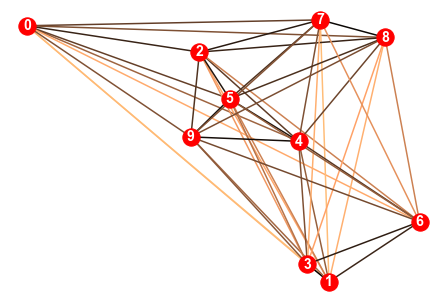

In [96]:
G = Graph(10, 'Euclidean')
draw(G)

##### Greedy search

Final cost 497.81101537594753
Final path [0, 2, 5, 9, 4, 6, 3, 1, 8, 7, 0]


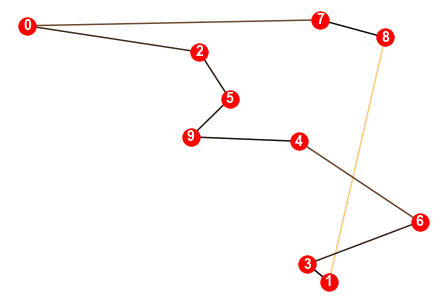

In [97]:
path, weight = greedy_nearest_neighbour(G)
print('Final cost', weight)
print('Final path', path)
draw(G, path)

##### Ant Colony Optimisation

Generation #1 best cost: 497.8110153759475, avg cost: 535.6472294965712, path: [1, 3, 6, 4, 9, 5, 2, 0, 7, 8, 1]
Generation #2 best cost: 491.0972779033278, avg cost: 519.9171400750522, path: [4, 9, 5, 2, 0, 7, 8, 6, 3, 1, 4]
Generation #3 best cost: 491.0972779033278, avg cost: 533.8346273401459, path: [4, 9, 5, 2, 0, 7, 8, 6, 3, 1, 4]
Generation #4 best cost: 491.0972779033278, avg cost: 519.9171400750522, path: [4, 9, 5, 2, 0, 7, 8, 6, 3, 1, 4]
Generation #5 best cost: 491.0972779033278, avg cost: 525.7992284591485, path: [4, 9, 5, 2, 0, 7, 8, 6, 3, 1, 4]
Generation #6 best cost: 491.0972779033278, avg cost: 524.5840698144979, path: [4, 9, 5, 2, 0, 7, 8, 6, 3, 1, 4]
Generation #7 best cost: 491.0972779033278, avg cost: 564.7949277794, path: [4, 9, 5, 2, 0, 7, 8, 6, 3, 1, 4]
Generation #8 best cost: 491.0972779033278, avg cost: 520.0142086855201, path: [4, 9, 5, 2, 0, 7, 8, 6, 3, 1, 4]
Generation #9 best cost: 491.0972779033278, avg cost: 525.7992284591485, path: [4, 9, 5, 2, 0, 7, 8

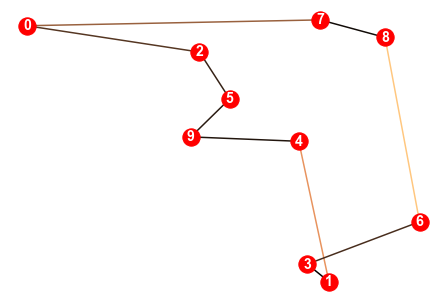

In [100]:
aco = AntColonyOptimisation(generations=10, ant_count=20, verbose=True)
path, weight = aco.solve(G)
print('Final cost', weight)
print('Final path', path)
draw(G, path)

The path found by Ant Colony Optimisation is better (shorter) even for a simple graph with 10 cities. By exploring the intermediate results generation by generation, we can see that the initial generations had worse solutions compared to Greedy Nearest Neighbour algorithm, but over generations it improved and surpassed it.

#### 4.1.5.2) Experiment 2: **Euclidean graphs**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on Euclidean graphs.
The comparison happens by increasing the city count in graph by 3 from 2 to 100 cities and repeating each test 5 times.

_Note: Higher values are better and values below 0 indicate performing worse._

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

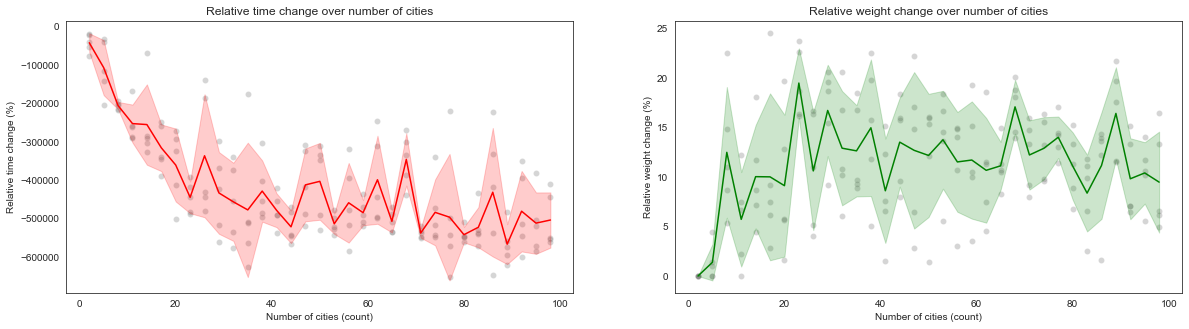

In [20]:
aco = AntColonyOptimisation(generations=10, ant_count=20)
comparison_results = compare_algorithms('Euclidean', lambda G: aco.solve(G))
graph_results(comparison_results)

For Euclidean graphs the time needed to compute a solution using Ant Colony Optimisation is around 5000 times more for 40-100 cities than the time needed to compute a solution using Greedy Nearest Neighbour algorithm. However, a solution produced by Ant Colony Optimisation is constantly 10-20% better.

It's important to think about the applications. For instance, if the solution takes an hour to compute, but it makes a day-long trip 20% shorter, it could save 4.8 hours from the trip. 

#### 4.1.5.3) Experiment 3: **Symmetric graphs**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on symmetric graphs.
The comparison happens by increasing the city count in graph by 3 from 2 to 100 cities and repeating each test 5 times.

_Note: Higher values are better and values below 0 indicate performing worse._

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

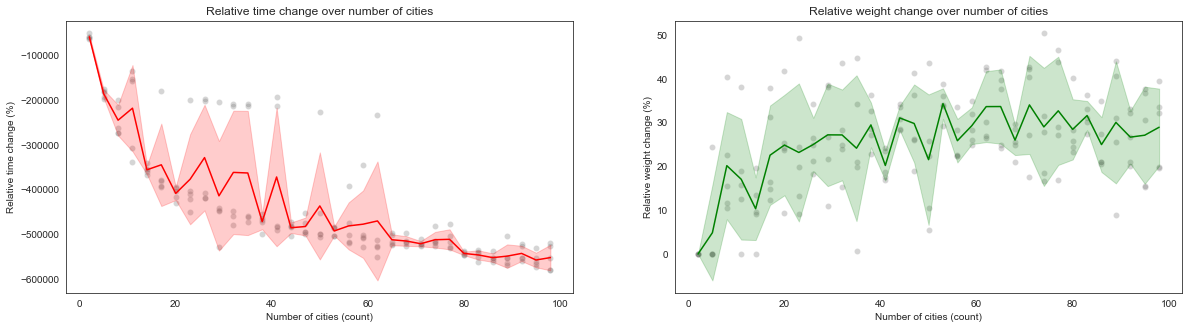

In [457]:
aco = AntColonyOptimisation(generations=10, ant_count=20)
comparison_results = compare_algorithms('symmetric', lambda G: aco.solve(G))
graph_results(comparison_results)

For symmetric graphs, the time needed to compute a solution using Ant Colony Optimisation over Greedy Nearest Neighbour algorithm is the same as for Euclidean graphs being 5000 times worse for 40-100 cities. However, the produced solution is on average 30% better which is a massive difference.

#### 4.1.5.4) Experiment 4: **Asymmetric graphs**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on asymmetric graphs.
The comparison happens by increasing the city count in graph by 3 from 2 to 100 cities and repeating each test 5 times.

_Note: Higher values are better and values below 0 indicate performing worse._

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

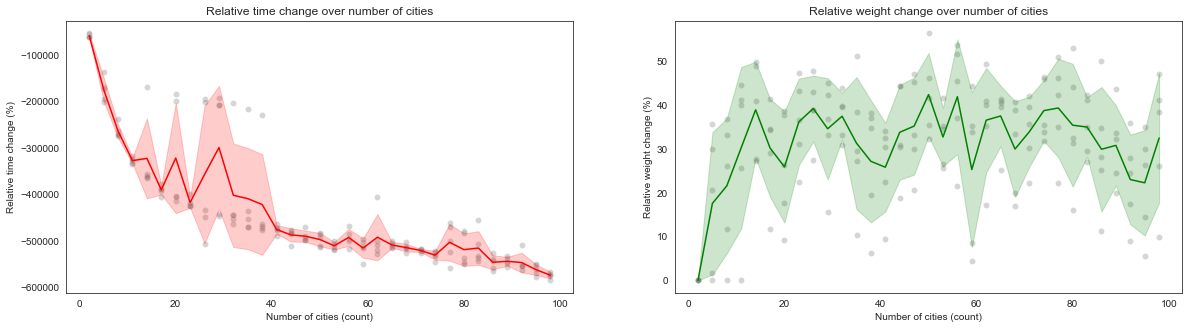

In [458]:
aco = AntColonyOptimisation(generations=10, ant_count=20)
comparison_results = compare_algorithms('asymmetric', lambda G: aco.solve(G))
graph_results(comparison_results)

Asymmetric graphs have the same relative time change as for Euclidean and symmetric graphs being 5000 times worse for 40-100 cities. However, the generated solution by the Ant Colony Optimisation is 25-50% better than the solution by Greedy Nearest Neighbour algorithm.

#### 4.1.5.5) Experiment 5: **Easy graphs**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on easy graphs.
The comparison happens by increasing the city count in graph by 3 from 2 to 100 cities and repeating each test 5 times.

_Note: Higher values are better and values below 0 indicate performing worse._

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

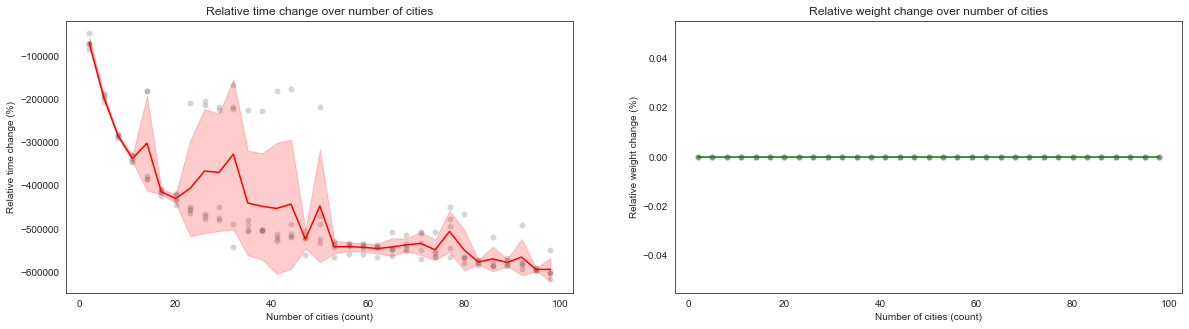

In [459]:
aco = AntColonyOptimisation(generations=10, ant_count=20)
comparison_results = compare_algorithms('easy', lambda G: aco.solve(G))
graph_results(comparison_results)

With easy graphs it's guaranteed that the Ant Colony Optimisation will find the best solution and so will Greedy Nearest Neighbour algorithm. Since the solutions are always the same, the downside of using Ant Colony Optimisation is that it takes 5000 times more time to compute a solution. 

#### 4.1.5.6) Experiment 6: **1000 city graph**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on a thousand city graph. The selected graph type for this experiment is Euclidean.

_Note: Higher values are better and values below 0 indicate performing worse._

In [27]:
aco = AntColonyOptimisation(generations=10, ant_count=20)
comparison_results = compare_algorithms('Euclidean', lambda G: aco.solve(G), n_range=[1000], repetitions=3)
comparison_results.groupby('n').agg(['mean'])

1000...

,time,quality
,mean,mean
n,,
1000.0,-1.306096e+06,2.241846


Whilst the Ant Colony Optimisation finds a better solution compared to Greedy Nearest Neighbour algorithm, the improvement is only 2%, while the time difference is massive. With the results from the previous experiments we would think that the Ant Colony Optimisation should be able to find a better solution, but the low ant and generation count doesn't explore enough of the search space to escape the local optimum, so the results are very similar to the greedy algorithm's. If rerun with around 100 generations and 100 or 1000 ants per generation, I expect that the results should have a higher quality, and with such a large ant count, the $beta$ (how likely an ant prefers a shorter route) constant should be decreased to below 4. However, calculating the solution for such a large graph would take a lot more time and need a faster machine and optimising the algorithm implementation to reduce the space complexity.

## 4.2) Genetic Algorithm

### 4.2.1) Definitions
* **Chromosome** - In this approach, a chromosome is a route that satisfies the rules for the TSP e.g. [1, 2, 3, 1]
* **Gene** - A component of a chromosome, in this case, a node from the graph e.g. [1]
* **Fitness** - How fit for purpose the chromosome is. In this approach lower fitness is better since fitness is determined as the cost of a path on the graph using the cost function
* **Population** - A collection of chromosomes
* **Selection** - The process of selecting two suitable parents from the population
* **Parents** - Two chromosomes that are selected to mate i.e. go through the crossover process
* **Crossover** - The process of combining two parents in some way to create a child or offspring
* **Mating pool** - A Collection of possible parents selected according to fitness that are used to populate the next generation
* **Mutation** - Mutation involves taking a chromosome and changing it very slightly in order to introduce a wider variance to the solution space
* **Elitism** - A portion of the most fit population that is kept and immediately placed into the next generation

### 4.2.2) Idea
Genetic algorithms are a subset of evolutionary algorithms. With the process of natural selection in mind, genetic algorithms use biologically inspired operators such as chromosomes, mutation, crossover, and selection to help surface an optimal solution after a number of generations. Whilst the main idea of creating a population and running operators across it for some amount of generations remains the same, genetic algorithms vary in implementation and parameter and operator selection, often to best suit the task at hand. The initial inspiration behind this approach was inspired by the paper "Genetic Algorithm for Traveling Salesman Problem with Modified Cycle Crossover Operator", where the authors' revised approach makes a substantial improvement in terms of solution quality over the already established algorithms (Hussain et al. 2017).

**The traditional Genetic Algorithm approach is outlined as follows** (Tsai et al. 2014):
1. Randomly generate an initial population of chromosomes.
2. Use the fitness function to select the fitter chromosomes.
3. Apply the crossover and mutation operators in order.
4. If a stopping criterion is satisfied, then stop and output the best chromosome.
5. Go to step 2.

In this approach, the traditional algorithm has been modified with inspiration from both "Genetic Algorithm for Traveling Salesman Problem with Modified Cycle Crossover Operator" and "A High-Performance Genetic Algorithm: Using Traveling Salesman Problem as a Case", where the papers present substantial improvements in terms of computational efficiency and solution quality over already established genetic algorithms for the TSP. This is largely achieved through careful operator modification and parameter selection in order to optimise the efficiency of the algorithm, consequently improving the quality of solutions (Hussain et al. 2017, Tsai et al. 2014). 

**The modified approach presented in this solution is as follows**: 
1. Create initial population of chromosomes via a mixture of random and heuristic initilisation (seed random solution pool with NN solution)
1. For each generation:
    1. Use elitism to keep a portion of the most fit members of the population (this approach keeps the 2 most fit)
    1. Iterate through the population of chromosomes
    1. Select two parents based on tournament selection
    1. Apply ordered crossover to the two selected parents in order to create a new child chromosome
    1. Apply mutation operator to the new child chromosome
    1. Add child to the next generation and repeat

#### 4.2.2.1) Selection Operator - Fitness Proportionate Selection
Fitness proportionate selection is used to select two parents for crossover and is defined as follows:
$\Large P_{c} = \frac{f_{c}}{\sum_{i=1}^{N} f_{i}}$

Where:
* $P_{c}$ is the probability of the chromosome being selected
* $f_{c}$ is the fitness of a chromosome $c$
* $N$ is the total size of the population

Fitness Proportionate Selection was initially implemented and tested proving to be more efficient but less effective than tournament selection. Note that since lower fitness scores are better in the TSP, the function must be altered (i.e. $P_{c} = \sum_{i=1}^{N} f_{i} - f_{c}$) to facilitate this.

<a id='tournament-selection'></a>
#### 4.2.2.2) Selection Operator - Tournament Selection
Tournament selection takes a random sample of the population $K$ and returns the two most fit chromosomes via sorting. In this approach the size of the tournament is limited to just 20 chromosomes as a tournament costs $O(K \log K)$ (obtained via Python's sorted function, aka Timsort) and a higher tournament size appears not to effect the quality of solutions enough for the efficiency cost to be worth it.

<a id='ordered-crossover'></a>
#### 4.2.2.3) Crossover Operator - Ordered Crossover (OX)

Since the Travelling Salesman Problem requires the solution to meet a set of specific criteria (a path between each of the nodes in a graph such that the path contains each node only once), the choice of crossover operator is restricted to crossover operators that would not produce a solution that would violate the constraints. In this approach, Ordered Crossover, as defined by Davis, has been selected due in part to this fact and part to the quality of documentation regarding the implementation (Davis, L. 1985).

Ordered Crossover as used in this implementation works as follows:
1. Create two random crossover points; one in each parent, copying the segment between them from parent A to the first component of the offspring.
1. Copy the genes that are not in use from the either parent A or parent B to the second component.
1. Combine the two components to form the offspring


<a id='uniform-mutation'></a>
#### 4.2.2.4) Mutation Operator - Uniform Mutation

Uniform Mutation is a simple mutation operator involving randomly selecting a gene and replacing it with an acceptable value. In this implementation, uniform mutation works by simply selecting a random gene from the chromosome and swapping it with another value (the value at the index of the randomly selected gene). The mutation operator in general is not supposed to severely alter the gene but rather to diversify the solution space and potentially break out of a situation where a local optima is reached. This mutation method was selected out of fit for purposeness as, like with selecting the crossover operator, there is a constraint on the produced solution.


### 4.2.3) Big O Analysis

Time Complexity: $O(n^{2} + (P \times G))$ = $O(n^{2})$

Where:
- **$P$** is the size of the population
- **$G$** is the amount of generations

This approach starts with $O(n^{2})$ since the population initialisation uses the nearest-neighbour algorithm once to influence the starting population. The population $P$ is then iterated over across $G$ generations applying relatively inconsequential operators, hence $P \times G$.

### 4.2.4) Pseudocode
The pseudocode documented below describes how the combination of functions work in conjunction with one another to define the Genetic Algorithm used in this approach.


**Input**: A graph where: $V$ is the list of graph vertices for some $N$ amount of nodes. $P$ is the maximum size of the population (i.e. array of chromosomes) and $G$ is the amount of generations (i.e. iterations).

**Output**: The path and total cost of the least costly path found in the population at the final generation.
1. $elitism \gets 2$ 
1. $tournament\_size \gets 20$
1. $mutation\_rate \gets 0.05$
1. $population \gets []$
1. Append $nearest\_neighbour(graph)$ to $population$
1. **for** $i \gets 1, ..., P-1$ **do**
1. $\quad\quad$ Append $\text{random_sample}(V, N)$ to $population$
1. **end for**
1. **for** $j \gets 1, ..., G$ **do**
1. $\quad\quad$ $next\_generation \gets \text{select_elite(population, elitism)}$ $\qquad\qquad \text{(i.e. take the two most fit chromosomes and add to next generation)}$
1. $\quad\quad$ **for** $k \gets 1, ..., population - elitism$ **do**
1. $\quad\quad\quad\quad parent\_a, parent\_b \gets \text{tournament_selection(population, tournament_size)}$ according to [Tournament Selection](#tournament-selection) (see section 4.2.2.2)
1. $\quad\quad\quad\quad \text{offspring} \gets \text{crossover(parent_a, parent_b)}$ according to [Ordered Crossover](#ordered-crossover) (see section 4.2.2.3)
1. $\quad\quad\quad\quad \text{offspring} \gets \text{mutate(offspring_a, mutation_rate)}$ according to [Uniform Mutation](#uniform-mutation) (see section 4.2.2.4)
1. $\quad\quad\quad\quad$ Append $\text{offspring}$ to $next\_generation$
1. $\quad\quad$ **end for**
1. $\quad\quad$ $population \gets next\_generation$
1. **end for**
1. **return** $population$ $\qquad\qquad \text{(as 0th element of population contains best path and lowest cost)}$

### 4.2.5) Implementation

In [8]:
class Chromosome:
    def __init__(self, chromosome, fitness):
        self.chromosome = chromosome
        self.fitness = fitness

class GA:

    def __init__(self, verbose=False, mr=0.5, tournament_size=20, elitism=2):
        self.verbose = verbose
        self.mr = mr  # mutation rate
        self.tournament_size = tournament_size
        self.elitism = elitism

    def __fitness(self, graph, chromosome) -> float:
        """
        Evaluate fitness by taking chromosome and appending first element to the end
        This is to check and return the fitness of the actual Hamlitonian cycle
        """
        x = chromosome.copy()
        x.append(x[0])  # Since complete cycle should be checked
        return cost(graph, x)

    def __proportionate_selection(self, population) -> Tuple[Chromosome, Chromosome]:
        """Fitness proportionate selection for two parents across population"""
        return choices(
            population=population,
            weights=[-chromosome.fitness for chromosome in population],
            k=2
        )
    
    def __tournament_selection(self, population) -> Tuple[Chromosome, Chromosome]:
        """Tournament selection to return two most fit parents"""
        parents = choices(population, k=self.tournament_size)
        parents = sorted(parents, key=lambda chromosome: chromosome.fitness)
        return parents[0], parents[1]

    def __create_population(self, graph, P) -> list[Chromosome]:
        """
        Create initial population of chromosomes P times
        Use nearest neighbour algorithm to 'seed' initial population
        Completely randomise the rest of the population
        """
        chromosomes = []
        initial_path, initial_weight = greedy_nearest_neighbour(graph)
        chromosomes.append(Chromosome(initial_path[:-1], initial_weight))
        for i in range(P-1):
            path = sample(graph.vertices.copy(), graph.n)
            fitness = self.__fitness(graph, path)
            chromosomes.append(Chromosome(path, fitness))
        return chromosomes

    def __crossover(self, parent_a, parent_b) -> list[int]:
        """Apply ordered crossover to two parents to produce a new chromosome"""
        partial_a = []
        partial_b = []
        gene_a, gene_b = choice(parent_a), choice(parent_b)
        for i in range(min(gene_a, gene_b), max(gene_a, gene_b)):
            partial_a.append(parent_a[i])
        partial_b = [gene for gene in parent_b if gene not in partial_a]
        chromosome = partial_a + partial_b
        return chromosome

    def __mutate(self, graph, chromosome) -> Chromosome:
        """Simple two point probability mutation - pick a random point and swap with value at index"""
        if random() < self.mr:
            pick = choice(chromosome)
            index = chromosome.index(pick)
            chromosome[index], chromosome[pick] = chromosome[pick], chromosome[index]
            chromosome = Chromosome(chromosome, self.__fitness(graph, chromosome))
        else:
            chromosome = Chromosome(chromosome, self.__fitness(graph, chromosome))
        return chromosome

    def ga_solve(self, graph, P=100, G=1000) -> Tuple[list[int], float]:
        """Combine functions to evolve population and iteratively find solution"""
        population = self.__create_population(graph, P)
        for generation in range(G):
            # Elitism is used to allow a portion of the most fit population to carry over
            keep = self.elitism
            # Since order isn't important at this stage, argpartition used for efficiency
            partition = np.argpartition([i.fitness for i in population], keep)[:keep]
            next_generation = [population[i] for i in partition]
            if self.verbose:
                if not generation % 25:
                    best = min(population, key=lambda chromosome: chromosome.fitness)
                    print(f"Generation: {generation}")
                    # print(f"Best solution: {best.chromosome}")
                    print(f"Fitness: {best.fitness}")
            for i in range(P - keep):
                parent_a, parent_b = self.__tournament_selection(population)
                offspring_a = self.__crossover(parent_a.chromosome, parent_b.chromosome)
                offspring_a = self.__mutate(graph, offspring_a)
                next_generation.append(offspring_a)
            population = next_generation

        best_solution = min(population, key=lambda chromosome: chromosome.fitness)
        best_solution.chromosome.append(best_solution.chromosome[0])  # Complete cycle
        return best_solution.chromosome, best_solution.fitness


### 4.2.6) Experiments

#### 4.2.6.1) Experiment 1: **A Single Euclidean Graph**
In this experiment a single Euclidean graph is generated, the solutions from both the Nearest Neighbour and Genetic algorithms are timed, drawn, and contrasted against eachother.

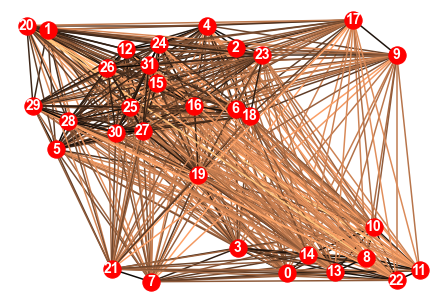

In [104]:
G = Graph(32, 'Euclidean')
draw(G)

**Greedy Nearest Neighbour Algorithm**

Final solution: [0, 14, 13, 8, 22, 11, 10, 3, 7, 21, 19, 27, 30, 25, 15, 31, 12, 26, 24, 4, 2, 23, 6, 18, 16, 28, 29, 5, 1, 20, 17, 9, 0]
Final cost: 1214.761323039994
Time spent: 0.00012309999874560162


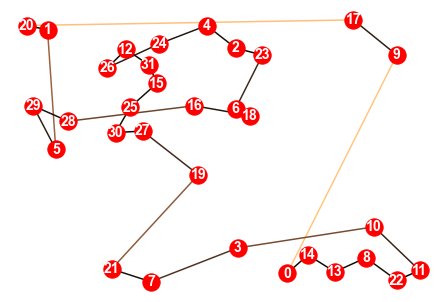

In [106]:
start_time = perf_counter()
path, weight = greedy_nearest_neighbour(G)
end_time = perf_counter()
draw(G, path)
print(f"Final solution: {path}")
print(f"Final cost: {weight}")
print(f"Time spent: {end_time - start_time}")


**Genetic Algorithm**

Final solution: [8, 13, 0, 7, 21, 19, 27, 30, 5, 29, 28, 25, 15, 31, 26, 20, 1, 12, 24, 4, 2, 23, 17, 9, 18, 6, 16, 3, 14, 10, 11, 22, 8]
Final cost: 1054.2719398243885
Time spent: 0.24138570000104664


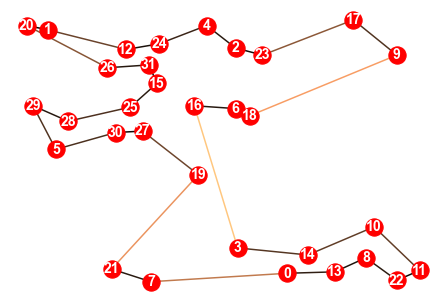

In [107]:
ga = GA()
start_time = perf_counter()
path, weight = ga.ga_solve(G, P=150, G=100)
end_time = perf_counter()
draw(G, path)
print(f"Final solution: {path}")
print(f"Final cost: {weight}")
print(f"Time spent: {end_time - start_time}")


Even with a small amount of generations, the Genetic Algorithm implementation builds an improved solution over the raw greedy nearest neighbour algorithm without a significant cost to time.

The results can of course be further improved by increasing the population size, though since the graph in this example has just 32 nodes, the local optima are more quickly reached, leaving less or no room for improvement in the later stages.

Final solution: [7, 21, 19, 18, 6, 16, 27, 30, 5, 29, 28, 25, 15, 31, 26, 20, 1, 12, 24, 4, 2, 23, 17, 9, 10, 11, 22, 8, 13, 14, 0, 3, 7]
Final cost: 980.2454475807001
Time spent: 3.91598680000061


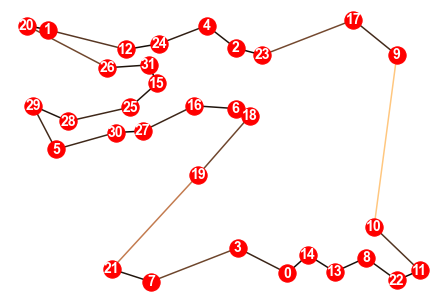

In [109]:
ga = GA()
start_time = perf_counter()
path, weight = ga.ga_solve(G, P=250, G=1000)
end_time = perf_counter()
draw(G, path)
print(f"Final solution: {path}")
print(f"Final cost: {weight}")
print(f"Time spent: {end_time - start_time}")

As expected, the solution is slightly improved but at a much greater cost to time. In the event where a solution is not required to be computed on the fly, it would be worthwhile to run the algorithm for a large amount of generations (with a threshold to ensure the algorithm doesn't get stuck) as even a slightly better route can make a big difference in the long run.

#### 4.2.6.2) Experiment 2: **Euclidean Graphs**

In this experiment we compare time and quality for the Genetic Algorithm against the Greedy Nearest Neighbour algorithm on Euclidean graphs. The comparison is made by incrementing the city count in the graph by 3, starting at 2 cities and going up to 100, repeating each test 5 times. A relatively small, uniform size population and generation count are used throughout the comparison which is not optimal - ideally the size of the parameters should scale with that of the problem. With this in mind, a middleground population and generation size of 200 and 250 respectively are used. 

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

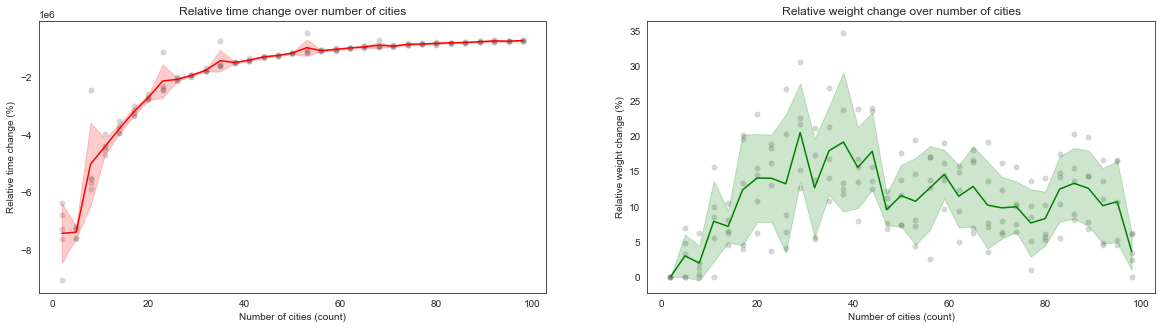

In [111]:
ga = GA()
comparison_results = compare_algorithms("Euclidean", lambda G: ga.ga_solve(G, P=200, G=450))
graph_results(comparison_results)

Even with a relatively small population and generation size, the Genetic Algorithm makes a consistent improvement over the Greedy Nearest Neighbour algorithm, by about 10-15% on average and at least 5% at any stage without too much of a cost to time at the higher city counts. The initial low score on relative time change can be explained by an unnecessarily large amount of generations being used on a small problem size (meaning that either the local optimum or the most optimal solution is quickly reached) and the lower score on the larger number of cities can be explained by simply not using a large enough population / generation size.

#### 4.2.6.3) Experiment 3: **Symmetric Graphs**

In this experiment we compare the time and quality of the Genetic Algorithm against the Greedy Nearest Neighbour algorithm on Symmetric graphs.

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

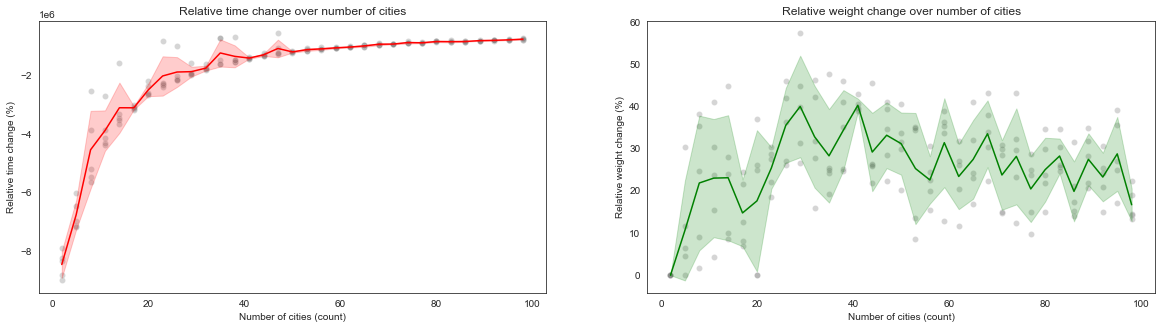

In [113]:
ga = GA()
comparison_results = compare_algorithms("symmetric", lambda G: ga.ga_solve(G, P=200, G=450))
graph_results(comparison_results)

Compared to euclidean graphs, a significantly better average improvement of 25-30% is reached with roughly the same time change over the number of cities. Like with euclidean graphs, the best improvements can be seen in the graphs with between 20 to 60 nodes - this makes sense given the averaged out population and generation count used (which should ideally be lower for the smallest graphs and higher for the largest).

#### 4.2.6.4) Experiment 4: **Asymmetric Graphs**

In this experiment we compare the time and quality of the Genetic Algorithm against the Greedy Nearest Neighbour algorithm on Asymmetric graphs.

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

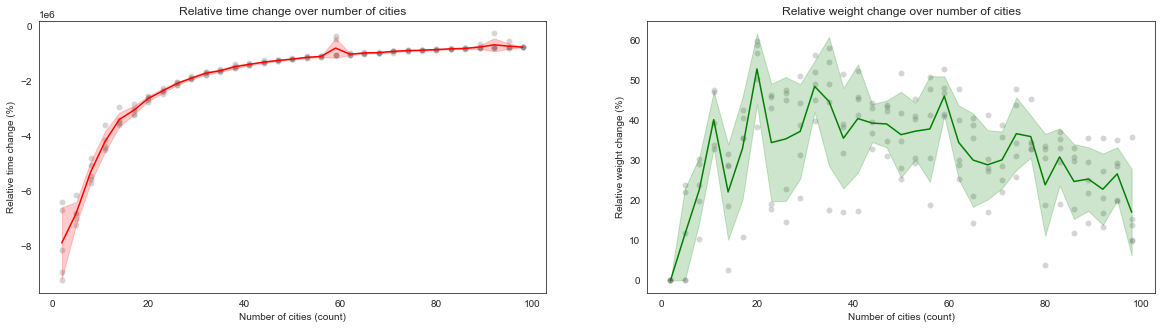

In [115]:
ga = GA()
comparison_results = compare_algorithms("asymmetric", lambda G: ga.ga_solve(G, P=200, G=450))
graph_results(comparison_results)

The improvements made across asymmetric graphs are much higher than all other types of graphs, reaching as high as even a 60% better solution compared to the nearest neighbour algorithm. As expected, this falls off as the number of cities increases (as previously explained).

#### 4.2.6.5) Experiment 5: **Easy Graphs**

In this experiment we compare the time and quality of the Genetic Algorithm against the Greedy Nearest Neighbour algorithm on Easy graphs.

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

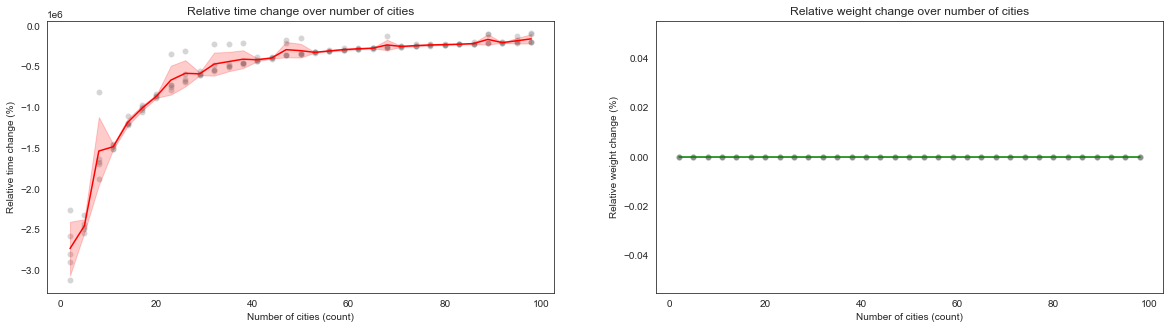

In [456]:
ga = GA()
comparison_results = compare_algorithms("easy", lambda G: ga.ga_solve(G, P=200, G=450))
graph_results(comparison_results)

As the optimal solution is consistently reached by the nearest neighbour algorithm, there are no room for improvements at all meaning that time is unecessarily spent when using the Genetic Algorithm approach.

#### 4.2.6.6) Experiment 6: **1000 Node Euclidean Graph**

In this final experiment the nearest neighbour and genetic algorithms are contrasted against each other on a 1000 Node Euclidean graph.

In [117]:
G = Graph(1000, "Euclidean")

**Greedy Nearest Neighbour Algorithm**

In [10]:
start_time = perf_counter()
path, weight = greedy_nearest_neighbour(G)
end_time = perf_counter()
print(f"Final cost: {weight}")
print(f"Time spent: {end_time - start_time}")

Final cost: 5954.6797458107685
Time spent: 0.06880959999944025


**Genetic Algorithm**

In [35]:
ga = GA(verbose=True)
start_time = perf_counter()
path, weight = ga.ga_solve(G, P=50, G=250)
end_time = perf_counter()
print(f"Final cost: {weight}")
print(f"Time spent: {end_time - start_time}")

Generation: 0
Fitness: 5954.6797458107685
Generation: 25
Fitness: 5954.6797458107685
Generation: 50
Fitness: 5942.630060935355
Generation: 75
Fitness: 5845.1479561140295
Generation: 100
Fitness: 5813.79891340007
Generation: 125
Fitness: 5813.79891340007
Generation: 150
Fitness: 5813.79891340007
Generation: 175
Fitness: 5813.79891340007
Generation: 200
Fitness: 5813.79891340007
Generation: 225
Fitness: 5813.79891340007
Final cost: 5813.79891340007
Time spent: 26.664004299997032


Whilst we manage to obtain an improvement, the time and space required to compute the solution compared to just using the Nearest Neighbour algorithm are massive. Across such a large graph, the algorithm should probably be tweaked fundamentally - for example, using a completely different crossover function, mutation strategy (as to mutate more of the chromosome), and higher mutation frequency. Even with a population size of just 50, at all stages we are still storing an array of length $50 * 1000 = 50,000$ requiring a large amount of memory especially when taking the operator functions into account. In such cases, the Genetic Algorithm is likely far from the best meta-heuristic to use.

### 4.2.7) Genetic Algorithm Conclusion

The Genetic Algorithm proves to be a viable algorithm in obtaining an improvement over the Greedy Nearest Neighbour algorithm - consistent improvements are made with varying time cost implications. There are many parameters to tweak with the Genetic Algorithm that lead to a huge variance in average solution quality - such as operator implementation (which crossover/mutation/selection strategy to use) and parameter value selection (which size population to use, how many generations to run for, and where to set the cut-off threshold). With these factors in mind, I believe that the Genetic Algorithm, whilst interesting and viable, is probably not the best metaheuristic to use for generating solutions to the Travelling Salesman Problem. When looking at further research however, it is shown that with studied parameter selection and problem-specific optimisations, more competitive solutions can be found (Fu et al. 2018).

The struggles in implementing the Genetic Algorithm for this problem have mostly came from operator limitations. Since the TSP has a hard requirement on what constitutes an acceptable solution, many tried and tested operators cannot be implemented or are simply inefficient to do so. Through experimenting with the algorithm, I found that seeding the initial population in some way becomes very important as the size of the problem grows. With a completely randomly sampled population, the generations required to beat the nearest neighbour algorithm are exponentially large so by seeding the population and by using elitism to maintain the two best chromosomes each generation, the algorithm can start to make improvements from a much better point with a marginal cost to time.

# 5) Metaheuristic algorithm comparison

This section explores which of the two metaheuristic algorithms should be recommended for which graphs by comparing them against each other on different amounts of cities in the graph for every 3 cities from 2 until 100.

**How to interpret the graphs**: A positive percentage indicates that Genetic Algorithm is performing better than Ant Colony Optimisation.

## 5.1) Comparison on Euclidean graphs

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

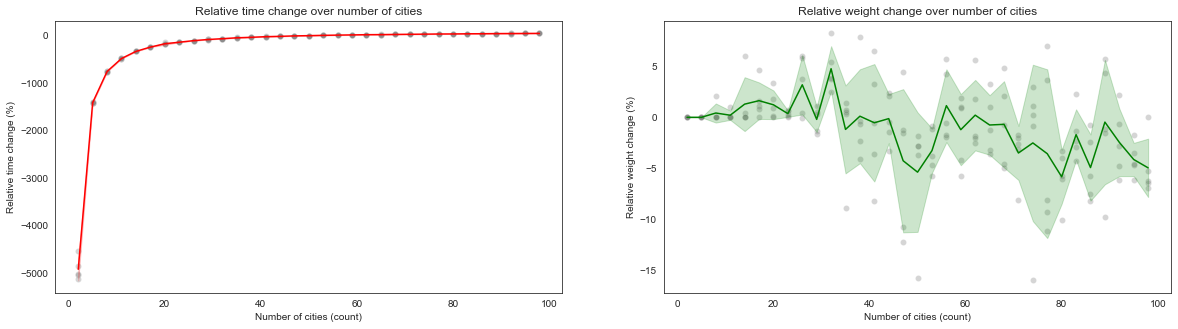

In [19]:
ga = GA()
aco = AntColonyOptimisation(generations=10, ant_count=20)
comparison_results = compare_algorithms('Euclidean',
                                        algorithm=lambda G: ga.ga_solve(G, P=150, G=250),
                                        baseline_algorithm=lambda G: aco.solve(G))
graph_results(comparison_results)

For all types of graphs (Euclidean, symmetric, and asymmetric) we can see a definite trend on the relative execution time. While on a low number of cities the difference appears "significant", it is actually just milliseconds away and we can notice it approaching 0% as the number of cities increase. This means that the running time of both algorithms is mostly influenced by the number of cities and since their time complexity is $O(n^2)$, the running time is basically the same.

On Euclidean graphs it's hard to argue which algorithm performs better. For graphs with up to 40 cities the Genetic Algorithm produces better results than the Ant Colony Optimisation, however for graphs with 40-100 cities Ant Colony Optimisation takes the lead. These results are hard to interpret as each test was rerun only 5 times leading to a small sample size. We can also see that results are both better and worse for any number of cities and the difference is a single digit percentage. The takeaway should be that both algorithms perform quite similarly.

## 5.2) Comparison on Symmetric graphs

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

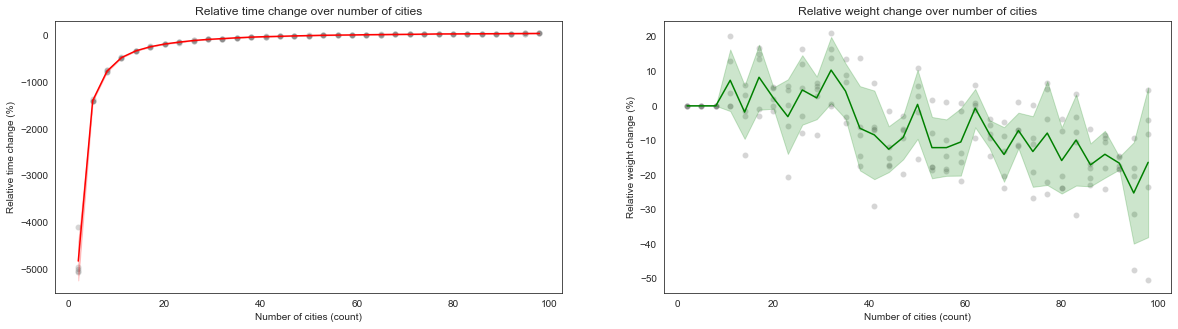

In [20]:
ga = GA()
aco = AntColonyOptimisation(generations=10, ant_count=20)
comparison_results = compare_algorithms('symmetric',
                                        algorithm=lambda G: ga.ga_solve(G, P=150, G=250),
                                        baseline_algorithm=lambda G: aco.solve(G))
graph_results(comparison_results)

For symmetric graphs the quality of the solution produced by Ant Colony Optimisation appears to be on average 10% better for graphs with 40-100 cities, whereas the quality with a lower number of cities appears to be better for Genetic Algorithm. It's interesting to notice that some solutions for graphs with over 90 cities are almost 50% better for Ant Colony Optimisation.

## 5.3) Comparison on Asymmetric graphs

2.....5.....8.....11.....14.....17.....20.....23.....26.....29.....32.....35.....38.....41.....44.....47.....50.....53.....56.....59.....62.....65.....68.....71.....74.....77.....80.....83.....86.....89.....92.....95.....98.....

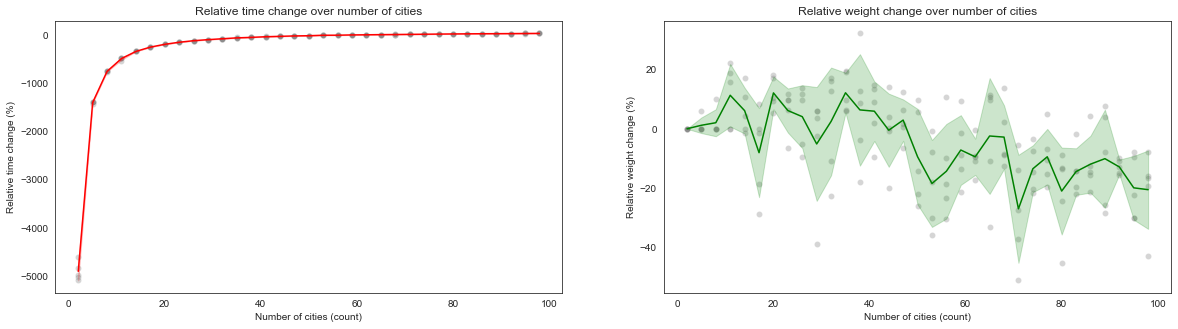

In [21]:
ga = GA()
aco = AntColonyOptimisation(generations=10, ant_count=20)
comparison_results = compare_algorithms('asymmetric',
                                        algorithm=lambda G: ga.ga_solve(G, P=150, G=250),
                                        baseline_algorithm=lambda G: aco.solve(G))
graph_results(comparison_results)

For asymmetric graphs the quality difference is similar to that of symmetric graphs.

## 5.4) Parameter selection

In [19]:
G = Graph(70, "Euclidean")

ga = GA()
aco = AntColonyOptimisation(generations=25, ant_count=50)

ga_start_time = perf_counter()
ga_path, ga_weight = ga.ga_solve(G, P=200, G=1500)
ga_end_time = perf_counter()

aco_start_time = perf_counter()
aco_path, aco_weight = aco.solve(G)
aco_end_time = perf_counter()

print(f"GA\nweight: {ga_weight}\ntime taken: {ga_end_time - ga_start_time}\npath: {ga_path}\n")
print(f"ACO\nweight: {aco_weight}\ntime taken: {aco_end_time - aco_start_time}\npath: {aco_path}")

GA
weight: 1354.9479394817308
time taken: 13.86602941700039
path: [4, 20, 29, 28, 49, 12, 31, 44, 43, 18, 33, 45, 8, 21, 61, 47, 60, 59, 0, 42, 54, 26, 9, 68, 51, 7, 32, 38, 25, 34, 39, 3, 69, 17, 10, 58, 57, 24, 52, 16, 2, 66, 67, 53, 50, 15, 64, 35, 27, 56, 30, 37, 41, 62, 22, 6, 11, 23, 55, 1, 13, 5, 65, 36, 19, 14, 63, 46, 48, 40, 4]

ACO
weight: 1428.599418669317
time taken: 12.537728833998699
path: [3, 38, 39, 69, 17, 10, 58, 57, 24, 52, 16, 67, 66, 2, 13, 1, 55, 23, 11, 6, 22, 30, 41, 62, 37, 56, 27, 35, 64, 15, 50, 53, 34, 25, 68, 9, 26, 14, 19, 36, 65, 5, 0, 42, 54, 59, 60, 21, 47, 61, 8, 45, 33, 18, 44, 31, 12, 49, 43, 63, 46, 28, 20, 4, 29, 40, 48, 51, 7, 32, 3]


Compared to the previous comparisons in which we can see that the Ant Colony Optimisation outperforms Genetic Algorithm, by just tweaking the parameters for each algorithm, we can achieve completely different results.

In this experiment, we increased the parameters until both algorithms took a similar time to execute on a 70 city graph.

For Ant Colony Optimisation we increased the generation count from 10 to 25 and the ant count from 20 to 50. For Genetic Algorithm we increased the population from 150 to 200 and the generations from 250 to 1500.

Both algorithms took around 13 seconds to execute on a 70 city Euclidean graph and the Genetic Algorithm's solution was comparably better, showing that instead of choosing the right algorithm, it's more important to select the right parameters.

# 6) Conclusion

In the current day and age where computational resources are still limited, the metaheuristics covered by the algorithms above are not guaranteed to find the most optimal route but instead strike a good balance between computing resources and quality of results.

Compared to the Greedy Nearest Neighbour algorithm, the metaheuristic algorithms produce solutions to the travelling salesman problem with a much higher quality (a lower total weight/distance of the route). The metaheuristic solution for Euclidean graphs produces on average around 15% shorter route. On symmetric graphs the produced route is around 30% shorter, while on asymmetric graphs the route can be as high as 60% shorter. The much better solutions for asymmetric graphs can also be attributed to the limitations in Greedy Nearest Neighbour algorithm, as it does not account for asymmetric paths.

While it might seem that the metaheuristic algorithms take a lot longer to produce a solution compared to the Greedy Nearest Neighbour, they all share the same polynomial time complexity of $O(n^2)$. The difference is initially so large mainly due to the added constants, which are the ant and generation count in Ant Colony Optimisation and the population and generation count in the Genetic Algorithm. On a sufficiently large graph, the relative execution time for all 3 algorithms would be almost the same. This can already be seen in the metaheuristic algorithm comparison, where the relative time difference starts approaching 0% as early as graphs with 25 cities.

The aforementioned constants also influence the quality of the solution. Using more ants or a bigger population will have a higher chance of producing better solutions. In the metaheuristic algorithm comparison, it appears that for more cities the Ant Colony Optimisation produces better solutions than the Genetic Algorithm, however, by tweaking the constants we can achieve completely different results. For example, using the same constants that achieved a 15% better solution compared to Greedy Nearest Neighbour algorithm on a 100-city graph, can only produce a 2% better solution for a 1000 city graph. It might be beneficial to determine these constants based on the number of cities, but this would influence the time complexity of the algorithms, especially for the Ant Colony Optimisation where the constants are multiplicative, compared to the Genetic Algorithm where the constants are additive.

As both metaheuristics aim to solve the travelling salesman problem using distinctly different optimization techniques, a direct comparison of the two is somewhat difficult. A study by Ujang and Sriwindono (2019) found that the Ant Colony Optimisation consistently produces better result while performing slower compared to the Genetic Algorithm. A similar study by Haroun et al (2015) also found virtually the same findings from comparison between the two, stating that Genetic Algorithm is faster and more cost efficient in terms of computational power, but Ant Colony Optimisation produces better results.

Nevertheless, the extent at which each algorithm performs better in their respective areas varies greatly depending on the parameters set for each algorithm, meaning that fine-tuning each algorithm for individual problems may be more integral in producing shorter distances than which algorithm is selected. From this, it is safe to say that neither one of these algorithms is better than the other in the general case. Ant Colony Optimisation does produce better results in general but considering the speed deficit, it may be better in some cases to use a very simple Greedy Nearest Neighbour algorithm where the execution time difference heavily outweighs the best cost difference and may prove to be more efficient than waiting a significantly longer time to produce a trivially better route.


# 7) References

- Dorigo, M., Maniezzo, V., Colorni, A. (1996). Ant system: optimization by a colony of cooperating agents. _IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics)_, 26(1), 29-41, https://ieeexplore.ieee.org/document/484436
- Le, J., Peechatt, M. (2019). Travel Time Optimization Problem via Ant Colony and Genetic Evolution. _Rochester Institute of Technology_, https://jameskle.com/s/Final-Report.pdf
- Pasquier, J. L., Balich, I. K., Carr, D. W., López-Martín, C. (2007). A Comparative Study of Three Metaheuristics Applied to the Traveling Salesman Problem. _Sixth Mexican International Conference on Artificial Intelligence, Special Session (MICAI)_, 243-254, https://ieeexplore.ieee.org/document/4659314
- Hussain, A., Muhammad, Y. S., Sajid, M. N., Hussain, I., Shoukry, A. M., Gani, S. (2017). Genetic Algorithm for Traveling Salesman Problem with Modified Cycle Crossover Operator, _Computational Intelligence and Neuroscience, vol. 2017_, https://doi.org/10.1155/2017/7430125
- Tsai, C., Tseng, S., Chiang, M., Yang, C., Hong, T. (2014). A High-Performance Genetic Algorithm: Using Traveling Salesman Problem as a Case, _The Scientific World Journal, vol. 2014_, https://doi.org/10.1155/2014/178621
- Davis, L. (1985). Job shop scheduling with genetic algorithms. _In Proceedings of an international conference on genetic algorithms and their applications (Vol. 140)_, https://books.google.co.uk/books?id=lI17AgAAQBAJ&lpg=PA136&ots=0Mk1d7M17s&dq=Job-shop%20%20Scheduling%20%20with%20%20Genetic%20%20Algorithms%E2%80%9D.&lr&pg=PA136#v=onepage&q=Job-shop%20%20Scheduling%20%20with%20%20Genetic%20%20Algorithms%E2%80%9D.&f=false
- Fu, C., Zhang, L., Wang, X., & Qiao, L. (2018). Solving TSP problem with improved genetic algorithm. _In AIP Conference Proceedings (Vol. 1967, No. 1, p. 040057). AIP Publishing LLC_, https://aip.scitation.org/doi/pdf/10.1063/1.5039131
- Larranaga, P., Kuijpers, C. M. H., Murga, R. H., Inza, I., & Dizdarevic, S. (1999). Genetic algorithms for the travelling salesman problem: A review of representations and operators. _Artificial Intelligence Review_, https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.118.2597&rep=rep1&type=pdf
- Ujang, A., Sriwindono, H. (2019). The Comparison of Genetic Algorithm and Ant Colony Optimization in Completing Travelling Salesman Problem. _Universitas Sanata Dharma_, https://eudl.eu/pdf/10.4108/eai.20-9-2019.2292121
- Haroun, S. A., Jamal, B., Hicham, E. H. (2015). A Performance Comparison of GA and ACO Applied to TSP. _International Journal of Computer Applications), 117(20), 28-35, https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.695.8041&rep=rep1&type=pdf
